<a href="https://colab.research.google.com/github/Sumirsht/GEDI/blob/main/GEDI_L4A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Searching and Downloading GEDI L4A Dataset**

This tutorial will demonstrate how to search and download Global Ecosystem Dynamics Investigation (GEDI) L4A Footprint Level Aboveground Biomass Density (AGBD) dataset. GEDI L4A dataset is available for the period starting 2019-04-17 and covers latitudes of 52 North to 52 South. GEDI L4A data files are natively in HDF5 format, and each file represents one International Space Station (ISS) orbit.

We will use NASA's Earthdata Common Metadata Repository (CMR) Application Programming Interface (API) to search for GEDI L4A files or granules for time and area of interest. CMR catalogs metadata records of NASA Earth Science data and make them available for easy programmatic access. Area of interest can be defined using a bounding box (Option 1) or using polygons (Option 2).

This tutorial requires the following Python modules installed in your system: requests, datetime, pandas, geopandas, shapely. Requirements are also in requirements.txt. To install the necessary Python modules, you can copy the requirements.txt from this repository and run:

pip install -r requirements.txt

In [53]:
%matplotlib inline
import requests
import datetime as dt
import pandas as pd
import geopandas as gpd
!pip install contextily # Corrected the pip install command
import contextily as ctx
from shapely.geometry import MultiPolygon, Polygon, box
from shapely.ops import orient

1. Searching with a bounding box (Option 1)
NASA EarthData's unique ID for this dataset (called Concept ID) is needed for searching the dataset. The dataset Digital Object Identifier or DOI can be used to obtain the Concept ID.

In [54]:
doi = '10.3334/ORNLDAAC/2056'# GEDI L4A DOI

# CMR API base url
cmrurl='https://cmr.earthdata.nasa.gov/search/'

doisearch = cmrurl + 'collections.json?doi=' + doi
response = requests.get(doisearch)
response.raise_for_status()
concept_id = response.json()['feed']['entry'][0]['id']

print(concept_id)

C2237824918-ORNL_CLOUD


In [55]:
# Nepal bounding box
bound = (80.058, 26.347, 88.201, 30.422)

# time bound
start_date = dt.datetime(2022, 1, 1) # specify your own start date
end_date = dt.datetime(2023, 1, 31)  # specify your end start date

This is the unique NASA-given concept ID for the GEDI 4A dataset, which can be used to retrieve relevant files (or granules) for GEDI L4A. For this tutorial, let's use a bounding box of Nepal, which extends north to south from (80.058, 26.347, 88.201, 30.422). We will download all the files for Janurary, 2022.

In [56]:
# CMR formatted start and end times
dt_format = '%Y-%m-%dT%H:%M:%SZ'
temporal_str = start_date.strftime(dt_format) + ',' + end_date.strftime(dt_format)

# CMR formatted bounding box
bound_str = ','.join(map(str, bound))

page_num = 1
page_size = 2000 # CMR page size limit

granule_arr = []

while True:

    # defining parameters
    cmr_param = {
        "collection_concept_id": concept_id,
        "page_size": page_size,
        "page_num": page_num,
        "temporal": temporal_str,
        "bounding_box[]": bound_str
    }

    granulesearch = cmrurl + 'granules.json'

    response = requests.get(granulesearch, params=cmr_param)
    response.raise_for_status()
    granules = response.json()['feed']['entry']

    if granules:
        for g in granules:
            granule_url = ''
            granule_poly = ''

            # read file size
            granule_size = float(g['granule_size'])

            # reading bounding geometries
            if 'polygons' in g:
                polygons= g['polygons']
                multipolygons = []
                for poly in polygons:
                    i=iter(poly[0].split (" "))
                    ltln = list(map(" ".join,zip(i,i)))
                    multipolygons.append(Polygon([[float(p.split(" ")[1]), float(p.split(" ")[0])] for p in ltln]))
                granule_poly = MultiPolygon(multipolygons)

            # Get URL to HDF5 files
            for links in g['links']:
                if 'title' in links and links['title'].startswith('Download') \
                and links['title'].endswith('.h5'):
                    granule_url = links['href']
            granule_arr.append([granule_url, granule_size, granule_poly])

        page_num += 1
    else:
        break

# adding bound as the last row into the dataframe
# we will use this later in the plot
b = list(bound)
granule_arr.append(['bound', 0, box(b[0], b[1], b[2], b[3])])

# creating a pandas dataframe
l4adf = pd.DataFrame(granule_arr, columns=["granule_url", "granule_size", "granule_poly"])

# Drop granules with empty geometry
l4adf = l4adf[l4adf['granule_poly'] != '']

print ("Total granules found: ", len(l4adf.index)-1)
print ("Total file size (MB): ", l4adf['granule_size'].sum())

Total granules found:  383
Total file size (MB):  129872.17096799999


Now, we have stored the granule URLs and their bounding geometries into the pandas dataframe l4adf. The first few rows of the table look like the following

In [57]:
l4adf.head()

granule_url  granule_size  \
0  https://data.ornldaac.earthdata.nasa.gov/prote...    311.808471   
1  https://data.ornldaac.earthdata.nasa.gov/prote...    358.155074   
2  https://data.ornldaac.earthdata.nasa.gov/prote...    306.037030   
3  https://data.ornldaac.earthdata.nasa.gov/prote...    376.193487   
4  https://data.ornldaac.earthdata.nasa.gov/prote...    312.192071   

                                        granule_poly  
0  MULTIPOLYGON (((17.0472622 51.7567062, 23.0223...  
1  MULTIPOLYGON (((57.3941078 -0.34812, 59.552349...  
2  MULTIPOLYGON (((23.2352562 51.7570953, 29.2164...  
3  MULTIPOLYGON (((63.5152702 -0.278396, 65.67452...  
4  MULTIPOLYGON (((17.8298073 51.7560692, 23.8136...

We can now plot the bounding geometries of the granules (shown with green lines in the figure below) using geopandas. The bounding box (of Lumbini) is plotted in red color.

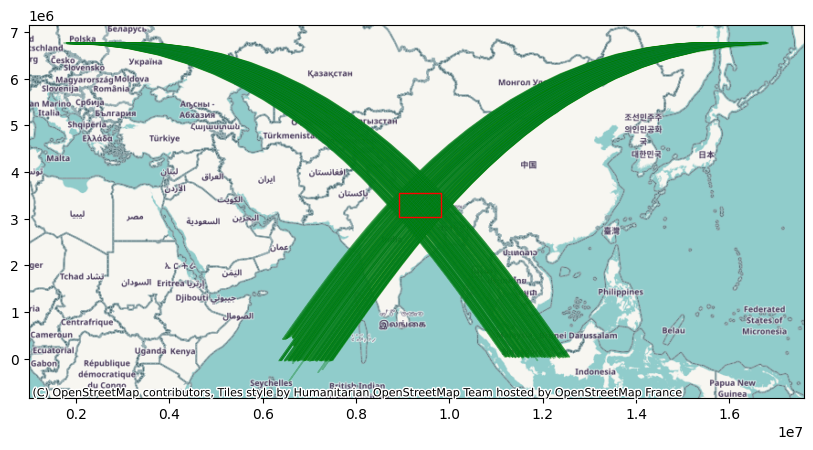

In [58]:
# creating a geopandas dataframe
gdf = gpd.GeoDataFrame(l4adf, geometry=l4adf.granule_poly)
# assiging CRS as WGS84
gdf.crs = "EPSG:4326"
# converting CRS to Web Mercator, the reference system of the contextily basemap
gdf_epsg3857 = gdf.to_crs(epsg=3857)
# plotting GEDI suborbits
ax=gdf_epsg3857[:-1].plot(figsize=(10, 5), alpha=0.3, edgecolor='green')
# plotting the bounding box (last row)
gdf_epsg3857[-1:].plot(ax=ax, facecolor='none', edgecolor='red')
# adding to contextily basemap
ctx.add_basemap(ax)

2. Searching for a polygonal area of interest (Option 2)
If an area of interest is already defined as a polygon, the polygon file (geojson, shapefile or kml) can be used to find overlapping GEDI L4A files. More details about this capability are described in this page.

For this tutorial, we will use the boundary of a northern states of TAL to search for the overlapping GEDI files. The boundary polygon is stored in a geojson file called amapa.json (shown in red polygon in the figure below).

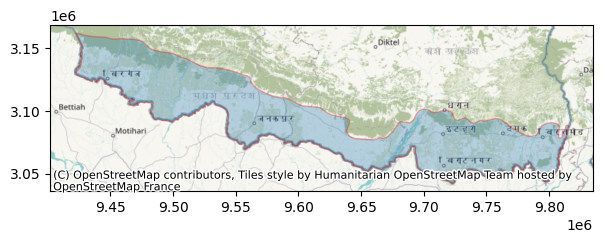

In [59]:
!pip install shapely --upgrade
from shapely.geometry import Polygon, MultiPolygon, box
from shapely.ops import orient # Correct import for orient
import zipfile

# Path to the zip file
zip_file_path = "/content/Terai.zip"

# Extract the zip file
with zipfile.ZipFile(zip_file_path, "r") as z:
    z.extractall("shapefile")  # Extract to the "shapefile" directory
import geopandas as gpd

import contextily as ctx

# Path to the shapefile (adjust the file name if needed)
# Use the actual file name extracted from the zip
# The 'list' method can help you see file names in zip file:
#    print(z.namelist())
shapefile_path = "shapefile/Terai.shp" # This line needs review

# Load the shapefile
Terai = gpd.read_file(shapefile_path)

# Ensure geometries are consistently oriented
Terai.geometry = Terai.geometry.apply(orient, args=(1,))

# Plot the shapefile with a basemap
ax = Terai.to_crs(epsg=3857).plot(figsize=(7, 7), alpha=0.3, edgecolor="red")
ctx.add_basemap(ax)

In this example, we will search for all the GEDI L4A files available for the area using the CMR API.

In [60]:
doi = '10.3334/ORNLDAAC/2056'  # GEDI L4A DOI

# CMR API base url
cmrurl = 'https://cmr.earthdata.nasa.gov/search/'

doisearch = cmrurl + 'collections.json?doi=' + doi
response = requests.get(doisearch)
response.raise_for_status()
concept_id = response.json()['feed']['entry'][0]['id']

# Simplify the geometry before sending it to the API
# This reduces the number of coordinates and the size of the request.
# Adjust the tolerance value as needed to balance simplification and accuracy.
simplified_geometry = Terai.geometry.simplify(tolerance=0.01)
geojson = {"shapefile": ("Terai.shp", simplified_geometry.to_json(), "application/geo+json")}


page_num = 1
page_size = 2000  # CMR page size limit

granule_arr = []

while True:

    # defining parameters
    cmr_param = {
        "collection_concept_id": concept_id,
        "page_size": page_size,
        "page_num": page_num,
        "simplify-shapefile": 'true'  # this is needed to bypass 5000 coordinates limit of CMR
    }

    granulesearch = cmrurl + 'granules.json'
    response = requests.post(granulesearch, data=cmr_param, files=geojson)

    # Check for errors and print the response content if there's an issue
    try:
        response.raise_for_status()
        granules = response.json()['feed']['entry']
    except requests.exceptions.HTTPError as e:
        print(f"Error: {e}")
        print(f"Response content: {response.content}")  # Print the response content for debugging
        break

    if granules:
        for g in granules:
            granule_url = ''
            granule_poly = ''

            # read file size
            granule_size = float(g['granule_size'])

            # reading bounding geometries
            if 'polygons' in g:
                polygons= g['polygons']
                multipolygons = []
                for poly in polygons:
                    i=iter(poly[0].split (" "))
                    ltln = list(map(" ".join,zip(i,i)))
                    multipolygons.append(Polygon([[float(p.split(" ")[1]), float(p.split(" ")[0])] for p in ltln]))
                granule_poly = MultiPolygon(multipolygons)

            # Get URL to HDF5 files
            for links in g['links']:
                if 'title' in links and links['title'].startswith('Download') \
                and links['title'].endswith('.h5'):
                    granule_url = links['href']
            granule_arr.append([granule_url, granule_size, granule_poly])

        page_num += 1
    else:
        break



# adding bound as the last row into the dataframe
# we will use this later in the plot
granule_arr.append(['Terai', 0, Terai.geometry.iloc[0] ])

# creating a pandas dataframe
l4adf = pd.DataFrame(granule_arr, columns=["granule_url", "granule_size", "granule_poly"])

# Drop granules with empty geometry
l4adf = l4adf[l4adf['granule_poly'] != '']

print ("Total granules found: ", len(l4adf.index)-1 )
print ("Total file size (MB): ", l4adf['granule_size'].sum())

Total granules found:  397
Total file size (MB):  134941.91772


In [61]:
l4adf.head()

granule_url  granule_size  \
0  https://data.ornldaac.earthdata.nasa.gov/prote...    327.606674   
1  https://data.ornldaac.earthdata.nasa.gov/prote...    364.342445   
2  https://data.ornldaac.earthdata.nasa.gov/prote...    382.521629   
3  https://data.ornldaac.earthdata.nasa.gov/prote...    345.101227   
4  https://data.ornldaac.earthdata.nasa.gov/prote...    345.538347   

                                        granule_poly  
0  MULTIPOLYGON (((22.9855709 51.7780952, 28.9771...  
1  MULTIPOLYGON (((63.2038345 0.030941, 65.364334...  
2  MULTIPOLYGON (((66.3303604 -0.01988, 68.491142...  
3  MULTIPOLYGON (((22.5689259 51.7785568, 28.5600...  
4  MULTIPOLYGON (((65.937088 0.049724, 68.0988235...

We can now plot the bounding geometries of the granules (shown with green lines in the figure below) using geopandas. The TAl state is plotted in red color.

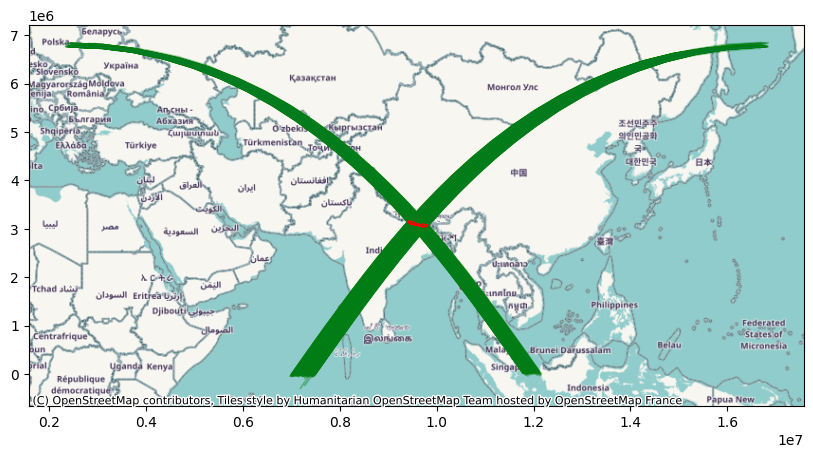

In [62]:
# creating a geopandas dataframe
gdf = gpd.GeoDataFrame(l4adf, geometry=l4adf.granule_poly)
# assiging CRS as WGS84
gdf.crs = "EPSG:4326"
# converting CRS to Web Mercator, the reference system of the contextily basemap
gdf_epsg3857 = gdf.to_crs(epsg=3857)
# plotting GEDI suborbits bounding geometry
ax=gdf_epsg3857[:-1].plot(figsize=(10, 5), alpha=0.3, edgecolor='green')
# plotting the bounding box (last row)
gdf_epsg3857[-1:].plot(ax=ax, facecolor='none', edgecolor='red')
# adding to contextily basemap
ctx.add_basemap(ax)

3. Downloading the files

We recommend using utilities such as cURL or wget to download the files. You will first need to set up NASA Earthdata Login authentication using .netrc file. Please refer to this page for details on setting up such authentication: https://wiki.earthdata.nasa.gov/display/EL/How+To+Access+Data+With+cURL+And+Wget.

Once the authentication has been setup (Steps 1-3 on the above page), the GEDI L4a files can be downloaded as follows.

First, save the granule URLs to a file granules.txt.

In [64]:
# drop duplicate URLs if any
l4a_granules = l4adf[:-1].drop_duplicates(subset=['granule_url'])
l4a_granules.to_csv('granules.txt', columns = ['granule_url'], index=False, header = False)

Either of the following commands can then be issued from the terminal to download the files.

wget
wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --auth-no-challenge=on --keep-session-cookies --content-disposition -nc -i granules.txt

curl
cat granules.txt | tr -d '\r' | xargs -n 1 curl -LJO -n -c ~/.urs_cookies -b ~/.urs_cookies

**Subsetting GEDI L4A Footprints**

This tutorial will demonstrate how to subset Global Ecosystem Dynamics Investigation (GEDI) L4A Footprint Level Aboveground Biomass Density (AGBD) dataset to a study area of interest. GEDI L4A dataset is available for the period starting 2019-04-17 and covers latitudes of 52 North to 52 South. GEDI L4A data files are natively in HDF5 format, and each file represents one International Space Station (ISS) orbit.

The previous tutorial explains how to download GEDI L4A files for a study area of interest (bounding box or polygon) and a specific period. Once all the GEDI L4A files are downloaded, the global orbits of GEDI L4A can be clipped or subsetted to the study area of interest.

This tutorial requires the following Python modules installed in your system: requests, numpy, h5py, datetime, pandas, geopandas, contextily, shapely. Requirements are also in requirements.txt. To install the necessary Python modules, you can copy the requirements.txt from this repository and run:

pip install -r requirements.txt

In [65]:
%matplotlib inline
import requests
import h5py
import pandas as pd
import geopandas as gpd
import contextily as ctx
import h5py
import numpy as np
from glob import glob
from os import path
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import orient

**1. Polygonal Area of Interest**

We will use the boundary of the Terai Arc Landscape to demonstrate the spatial subsetting process. The boundary file is in ESRI Shapefile format in the folder called TAL. Let's read the boundary file and print out its coordinate system.

In [67]:
Terai_poly = gpd.read_file('/content/shapefile/Terai.shp')
Terai_poly.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

 Now let's plot our study area over a base map. First, we will convert to Tal polygon into Web Mercator (EPSG 3857) to bring it to the same coordinate reference system as the base map. If it's in same web mercator don't need to change it.

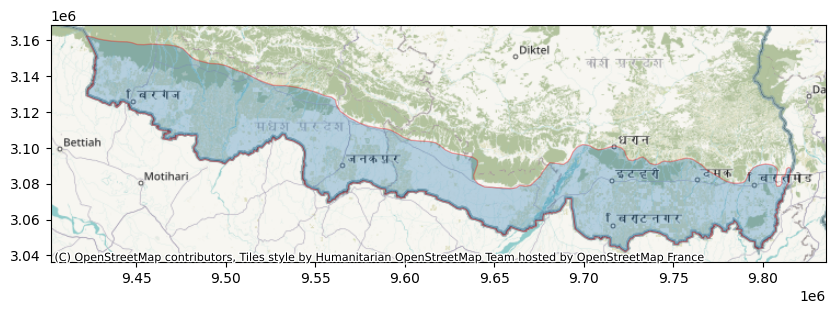

In [68]:
Terai_epsg3857 = Terai_poly.to_crs(epsg=3857)
ax=Terai_epsg3857.plot(figsize=(10, 5), alpha=0.3, edgecolor='red')
ctx.add_basemap(ax)

In [69]:
# converting to WGS84 coordinate system
Terai_epsg4326 = Terai_poly.to_crs(epsg=4326)

# orienting coordinates clockwise
Terai_epsg4326.geometry = Terai_epsg4326.geometry.apply(orient, args=(1,))

# reducing number of vertices in the polygon
# CMR has 1000000 bytes limit
Terai_epsg4326 = Terai_epsg4326.simplify(0.0005)

doi = '10.3334/ORNLDAAC/2056'  # GEDI L4A DOI

# CMR API base url
cmrurl = 'https://cmr.earthdata.nasa.gov/search/'

doisearch = cmrurl + 'collections.json?doi=' + doi
response = requests.get(doisearch)
response.raise_for_status()
concept_id = response.json()['feed']['entry'][0]['id']

# Simplify the geometry before sending it to the API
# This reduces the number of coordinates and the size of the request.
# Adjust the tolerance value as needed to balance simplification and accuracy.
simplified_geometry = Terai.geometry.simplify(tolerance=0.01)
geojson = {"shapefile": ("Terai.shp", Terai_epsg4326.geometry.to_json(), "application/geo+json")}


page_num = 1
page_size = 2000  # CMR page size limit

granule_arr = []

while True:

    # defining parameters
    cmr_param = {
        "collection_concept_id": concept_id,
        "page_size": page_size,
        "page_num": page_num,
        "simplify-shapefile": 'true'  # this is needed to bypass 5000 coordinates limit of CMR
    }

    granulesearch = cmrurl + 'granules.json'
    response = requests.post(granulesearch, data=cmr_param, files=geojson)

    # Check for errors and print the response content if there's an issue
    try:
        response.raise_for_status()
        granules = response.json()['feed']['entry']
    except requests.exceptions.HTTPError as e:
        print(f"Error: {e}")
        print(f"Response content: {response.content}")  # Print the response content for debugging
        break

    if granules:
        for g in granules:
            granule_url = ''
            granule_poly = ''

            # read file size
            granule_size = float(g['granule_size'])

            # reading bounding geometries
            if 'polygons' in g:
                polygons= g['polygons']
                multipolygons = []
                for poly in polygons:
                    i=iter(poly[0].split (" "))
                    ltln = list(map(" ".join,zip(i,i)))
                    multipolygons.append(Polygon([[float(p.split(" ")[1]), float(p.split(" ")[0])] for p in ltln]))
                granule_poly = MultiPolygon(multipolygons)

            # Get URL to HDF5 files
            for links in g['links']:
                if 'title' in links and links['title'].startswith('Download') \
                and links['title'].endswith('.h5'):
                    granule_url = links['href']
            granule_arr.append([granule_url, granule_size, granule_poly])

        page_num += 1
    else:
        break



# adding bound as the last row into the dataframe
# we will use this later in the plot
granule_arr.append(['Terai', 0, Terai_epsg4326.geometry.iloc[0] ])

# creating a pandas dataframe
l4adf = pd.DataFrame(granule_arr, columns=["granule_url", "granule_size", "granule_poly"])

# Drop granules with empty geometry
l4adf = l4adf[l4adf['granule_poly'] != '']

print ("Total granules found: ", len(l4adf.index)-1 )
print ("Total file size (MB): ", l4adf['granule_size'].sum())

Total granules found:  397
Total file size (MB):  134941.91772


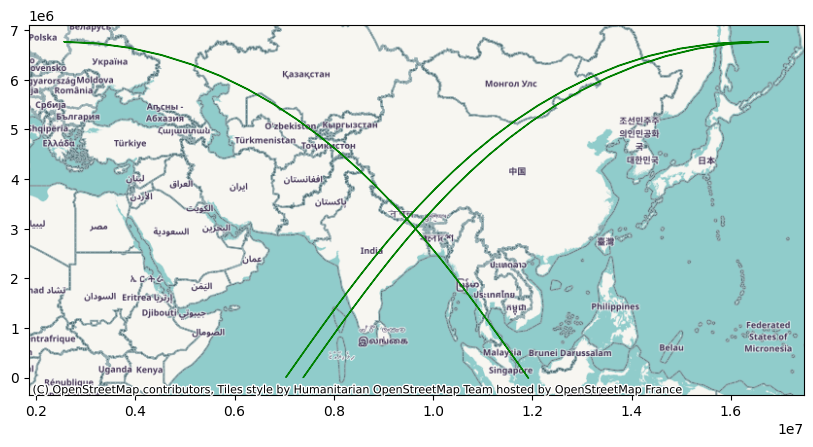

In [70]:

gdf = gpd.GeoDataFrame(l4adf, geometry=l4adf.granule_poly)
gdf.crs = "EPSG:4326"
gdf_epsg3857 = gdf.to_crs(epsg=3857)
ax=gdf_epsg3857[:3].plot(figsize=(10, 5),edgecolor='green')
ctx.add_basemap(ax)


Each GEDI L4A file extends beyond the study area of interest. Now, let's plot a zoomed-in version of the above map over GRSM.

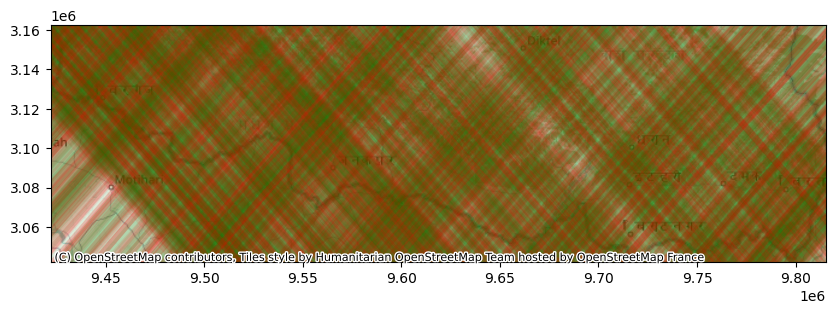

In [71]:
ax2=gdf_epsg3857[:-1].plot(figsize=(10, 5), alpha=0.1, color='green', edgecolor='red', linewidth=5)
minx, miny, maxx, maxy = Terai_epsg3857.total_bounds
ax2.set_xlim(minx, maxx)
ax2.set_ylim(miny, maxy)
ctx.add_basemap(ax2)

As we see in the figures above, GEDI has a good coverage over the TAL area.

**3. Downloading the GEDI L4A files**

We will now save the granule URLS into a file granules.txt and use wget command in the terminal to download all the 136 files. Please refer to the previous tutorial for more details on downloading programmatically.

In [72]:
# drop duplicate URLs if any
l4a_granules = l4adf[:-1].drop_duplicates(subset=['granule_url'])
l4a_granules.to_csv('granules.txt', columns = ['granule_url'], index=False, header = False)

**4. Subsetting the GEDI L4A files**

Once all the GEDI L4A files are downloaded, we can clip the full orbit files to retrieve the footprints that fall within the area of interest, i.e. GRSM boundary. We have downloaded all the files to a folder called full_orbits for this tutorial.

**4a. Exploring the data structure**

Let's first open one of the L4A file GEDI04_A_2019108015253_O01960_02_T03910_02_002_02_V002.h5 we just downloaded and print the root-level variable group.

In [96]:
hf = h5py.File('/content/full_orbits/GEDI04_A_2022310154410_O22096_02_T08745_02_003_01_V002.h5', 'r')
hf.keys()

<KeysViewHDF5 ['ANCILLARY', 'BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011', 'METADATA']>

All science variables are organized by eight beams of the GEDI. Please refer to the GEDI L4A user guide and GEDI L4A data dictionary for details on file organization. Let's look into one of the beam group BEAM0110 and print all the science dataset (SDS) variables within the group.

In [97]:
beam0110 = hf.get('BEAM0110')
beam0110.keys()

<KeysViewHDF5 ['agbd', 'agbd_pi_lower', 'agbd_pi_upper', 'agbd_prediction', 'agbd_se', 'agbd_t', 'agbd_t_se', 'algorithm_run_flag', 'beam', 'channel', 'degrade_flag', 'delta_time', 'elev_lowestmode', 'geolocation', 'l2_quality_flag', 'l4_quality_flag', 'land_cover_data', 'lat_lowestmode', 'lon_lowestmode', 'master_frac', 'master_int', 'predict_stratum', 'predictor_limit_flag', 'response_limit_flag', 'selected_algorithm', 'selected_mode', 'selected_mode_flag', 'sensitivity', 'shot_number', 'solar_elevation', 'surface_flag', 'xvar']>

In the above list of variables, 2 science dataset (SDS) are particulary useful for spatial subsetting: lat_lowestmode and lon_lowestmode, which represent ground location of each GEDI shot.

Let's plot all the beams in the map.

In [98]:
lat_l = []
lon_l = []
beam_n = []
for var in list(hf.keys()):
    if var.startswith('BEAM'):
        beam = hf.get(var)
        lat = beam.get('lat_lowestmode')[:]
        lon = beam.get('lon_lowestmode')[:]
        lat_l.extend(lat.tolist()) # latitude
        lon_l.extend(lon.tolist()) # longitude
        n = lat.shape[0] # number of shots in the beam group
        beam_n.extend(np.repeat(str(var), n).tolist())
geo_arr = list(zip(beam_n,lat_l,lon_l))
l4adf = pd.DataFrame(geo_arr, columns=["beam", "lat_lowestmode", "lon_lowestmode"])
l4adf

beam  lat_lowestmode  lon_lowestmode
0        BEAM0000       -0.375161       63.086970
1        BEAM0000       -0.374739       63.087266
2        BEAM0000       -0.374317       63.087563
3        BEAM0000       -0.373895       63.087859
4        BEAM0000       -0.373474       63.088156
...           ...             ...             ...
1336452  BEAM1011       51.775845      146.716549
1336453  BEAM1011       51.775850      146.717386
1336454  BEAM1011       51.775853      146.718212
1336455  BEAM1011       51.775854      146.719024
1336456  BEAM1011       51.775858      146.719858

[1336457 rows x 3 columns]

The pandas dataframe l4adf contains beam names, latitude and longitude columns. This particular GEDI orbit recorded a total of 1,338,249 shots. Now we can convert l4adf to a geopandas dataframe l4agdf and clip the file by the boundary of the GRSM.

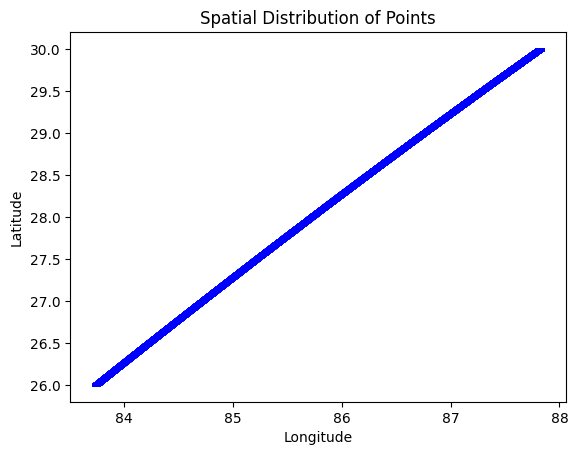

In [99]:
l4adf = l4adf[(l4adf['lat_lowestmode'] >= 26) & (l4adf['lat_lowestmode'] <= 30) &
              (l4adf['lon_lowestmode'] >= 80) & (l4adf['lon_lowestmode'] <= 89)]
import matplotlib.pyplot as plt

plt.scatter(l4adf['lon_lowestmode'], l4adf['lat_lowestmode'], s=1, color='blue')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Distribution of Points')
plt.show()


In [100]:
print(Terai_epsg4326.crs)
print(l4adf)


EPSG:4326
             beam  lat_lowestmode  lon_lowestmode
63736    BEAM0000       26.000288       83.711037
63737    BEAM0000       26.000676       83.711414
63738    BEAM0000       26.001065       83.711791
63739    BEAM0000       26.001453       83.712167
63740    BEAM0000       26.001842       83.712544
...           ...             ...             ...
1243639  BEAM1011       29.998245       87.852247
1243640  BEAM1011       29.998619       87.852655
1243641  BEAM1011       29.998994       87.853062
1243642  BEAM1011       29.999368       87.853470
1243643  BEAM1011       29.999738       87.853879

[83079 rows x 3 columns]


In [101]:
l4agdf = gpd.GeoDataFrame(l4adf, geometry=gpd.points_from_xy(l4adf.lon_lowestmode, l4adf.lat_lowestmode))
l4agdf.crs = "EPSG:4326"
l4agdf = l4agdf.to_crs(Terai_epsg4326.crs)
print(l4agdf)
l4agdf_terai = l4agdf[l4agdf['geometry'].within(Terai_epsg4326.geometry.iloc[0])]
#print(l4agdf_terai)


             beam  lat_lowestmode  lon_lowestmode                   geometry
63736    BEAM0000       26.000288       83.711037  POINT (83.71104 26.00029)
63737    BEAM0000       26.000676       83.711414  POINT (83.71141 26.00068)
63738    BEAM0000       26.001065       83.711791  POINT (83.71179 26.00106)
63739    BEAM0000       26.001453       83.712167  POINT (83.71217 26.00145)
63740    BEAM0000       26.001842       83.712544  POINT (83.71254 26.00184)
...           ...             ...             ...                        ...
1243639  BEAM1011       29.998245       87.852247  POINT (87.85225 29.99824)
1243640  BEAM1011       29.998619       87.852655  POINT (87.85265 29.99862)
1243641  BEAM1011       29.998994       87.853062  POINT (87.85306 29.99899)
1243642  BEAM1011       29.999368       87.853470  POINT (87.85347 29.99937)
1243643  BEAM1011       29.999738       87.853879  POINT (87.85388 29.99974)

[83079 rows x 4 columns]


In [102]:
print(l4agdf.crs)
print(Terai_epsg4326.crs)
print(l4agdf.is_valid.all())  # Should return True
print(Terai_epsg4326.is_valid.all())  # Should return True
print(l4agdf.geometry.head())
print(Terai_epsg4326.geometry[0])


EPSG:4326
EPSG:4326
True
True
63736    POINT (83.71104 26.00029)
63737    POINT (83.71141 26.00068)
63738    POINT (83.71179 26.00106)
63739    POINT (83.71217 26.00145)
63740    POINT (83.71254 26.00184)
Name: geometry, dtype: geometry
POLYGON ((84.64000622985526 27.31248473716109, 84.64012568919046 27.312307356077067, 84.64043871895316 27.31234712742701, 84.64456587224572 27.31287149439252, 84.66920023212403 27.308772077033794, 84.69867722373488 27.300723850048076, 84.72587033268007 27.29613449807753, 84.76641953741637 27.2909662448174, 84.80057351189515 27.288836081931443, 84.84321730085219 27.287777371528062, 84.86861144607744 27.28363616776581, 84.89370820334767 27.27603920481312, 84.92684285026853 27.275035861140484, 84.96259010696775 27.277680940869505, 85.00727587257973 27.275626164124414, 85.04965208701445 27.273804698254075, 85.09018118658392 27.26831747096004, 85.12089183552413 27.259011337548003, 85.14222640883682 27.240605932935708, 85.16582667105388 27.219416200841447, 85

The geopandas dataframe l4agdf_tal contains the shots (3588 shots in total) that fall within the TAL boundary. Now, let's plot these into a map.

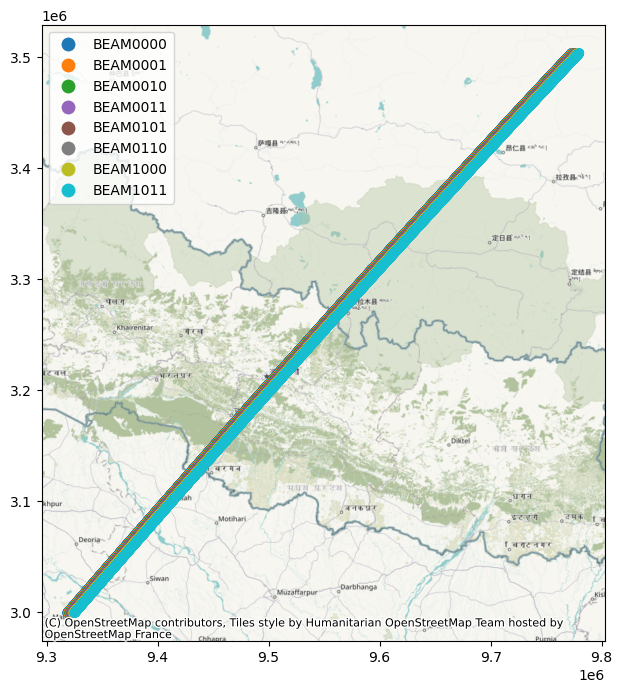

In [103]:
l4agdf_terai_epsg3857 = l4agdf.to_crs(epsg=3857)
ax2=l4agdf_terai_epsg3857.plot(column='beam', legend=True, figsize=(10, 8))
ctx.add_basemap(ax2)

The above map shows the swath coverage of GEDI - a typical swath is ~4200m wide. GEDI instrument produces eight ground tracks plotted in the map with different colors. Let's zoom in into an area and look at the locations of actual shots.

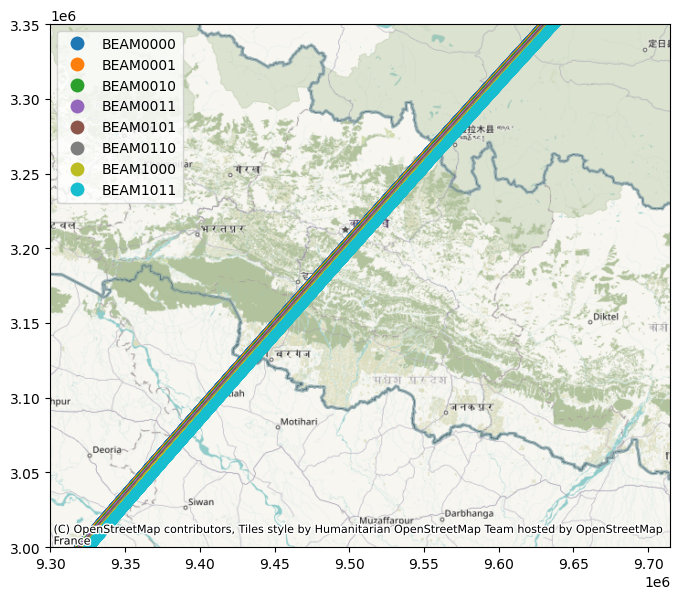

In [104]:
minx1, miny1, maxx1, maxy1 = [9300000, 3000000, 9715000, 3350000]
ax3=l4agdf_terai_epsg3857.plot(column='beam', legend=True, figsize=(8, 10))
ax3.set_xlim(minx1, maxx1)
ax3.set_ylim(miny1, maxy1)
ctx.add_basemap(ax3)

# close the opened hdf5 file
hf.close()

**4b. Subsetting all downloaded files**

In the Steps 2 and 3 above, we downloaded L4A files into the directory full_orbits. We will now loop over each of these files and create a clipped version of the files into a new directory subsets.

In [105]:
import os
from glob import glob
from os import path
import h5py
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import orient

indir = 'full_orbits'
outdir = 'subsets'

# Check if 'subsets' exists and handle the case if it's not a directory
if os.path.exists(outdir):
    if not os.path.isdir(outdir):
        # If it's a file, rename it or delete it (be cautious with deleting)
        # Here, we'll rename it by adding "_old" to the name
        os.rename(outdir, outdir + "_old")
    # If 'subsets' was a file, it is now renamed, so create a directory
    # Also, if 'subsets' was already a directory, creating again will not cause errors.
    os.makedirs(outdir, exist_ok=True)
else:
    # If it doesn't exist, create it
    os.makedirs(outdir)

# converting to WGS84 coordinate system
Terai_epsg4326 = Terai_poly.to_crs(epsg=4326)


for infile in glob(path.join(indir, 'GEDI04_A*.h5')):
    name, ext = path.splitext(path.basename(infile))
    subfilename = "{name}_sub{ext}".format(name=name, ext=ext)
    outfile = path.join(outdir, path.basename(subfilename))

    # Ensure the output file is closed before attempting to open it again
    if os.path.exists(outfile):
        try:
            with h5py.File(outfile, 'r') as f:  # Open in read mode to check if open
                pass  # If it opens successfully, it's likely in use
            os.remove(outfile)  # Remove the existing file
        except OSError:
            pass  # If it can't be opened in read mode, it's probably safe to overwrite

    with h5py.File(infile, 'r') as hf_in, h5py.File(outfile, 'w') as hf_out: # Using 'with' to ensure files are closed

        # copy ANCILLARY and METADATA groups
        var1 = ["/ANCILLARY", "/METADATA"]
        for v in var1:
            hf_in.copy(hf_in[v],hf_out)

        # loop through BEAMXXXX groups
        for v in list(hf_in.keys()):
            if v.startswith('BEAM'):
                beam = hf_in[v]
                # find the shots that overlays the area of interest (TAL)
                lat = beam['lat_lowestmode'][:]
                lon = beam['lon_lowestmode'][:]
                i = np.arange(0, len(lat), 1) # index
                geo_arr = list(zip(lat,lon, i))
                l4adf = pd.DataFrame(geo_arr, columns=["lat_lowestmode", "lon_lowestmode", "i"])
                l4agdf = gpd.GeoDataFrame(l4adf, geometry=gpd.points_from_xy(l4adf.lon_lowestmode, l4adf.lat_lowestmode))
                l4agdf.crs = "EPSG:4326"
                l4agdf_terai = l4agdf[l4agdf['geometry'].within(Terai_epsg4326.geometry.iloc[0])]
                indices = l4agdf_terai.i

                # copy BEAMS to the output file
                for key, value in beam.items():
                    if isinstance(value, h5py.Group):
                        for key2, value2 in value.items():
                            group_path = value2.parent.name
                            group_id = hf_out.require_group(group_path)
                            dataset_path = group_path + '/' + key2
                            hf_out.create_dataset(dataset_path, data=value2[:][indices])
                            for attr in value2.attrs.keys():
                                hf_out[dataset_path].attrs[attr] = value2.attrs[attr]
                    else:
                        group_path = value.parent.name
                        group_id = hf_out.require_group(group_path)
                        dataset_path = group_path + '/' + key
                        hf_out.create_dataset(dataset_path, data=value[:][indices])
                        for attr in value.attrs.keys():
                            hf_out[dataset_path].attrs[attr] = value.attrs[attr]

Now, new the subset files are created in the subsets directory. We will use the subset files to create a map of above ground biomass density (the variable agbd inside BEAMXXXX groups) of the TAL.

In [106]:
lat_l = []
lon_l = []
agbd = []
outdir = 'subsets'
for subfile in glob(path.join(outdir, 'GEDI04_A*.h5')):
    hf_in = h5py.File(subfile, 'r')
    for v in list(hf_in.keys()):
        if v.startswith('BEAM'):
            beam = hf_in[v]
            lat_l.extend(beam['lat_lowestmode'][:].tolist())
            lon_l.extend(beam['lon_lowestmode'][:].tolist())
            agbd.extend(beam['agbd'][:].tolist())
    hf_in.close()
geo_arr = list(zip(agbd,lat_l,lon_l))
df = pd.DataFrame(geo_arr, columns=["agbd", "lat_lowestmode", "lon_lowestmode"])
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon_lowestmode, df.lat_lowestmode))
gdf

agbd  lat_lowestmode  lon_lowestmode                   geometry
0     -9999.000000       27.111161       85.521014  POINT (85.52101 27.11116)
1     -9999.000000       27.110776       85.521396   POINT (85.5214 27.11078)
2     -9999.000000       27.110390       85.521779  POINT (85.52178 27.11039)
3     -9999.000000       27.110006       85.522162  POINT (85.52216 27.11001)
4     -9999.000000       27.109623       85.522542  POINT (85.52254 27.10962)
...            ...             ...             ...                        ...
38614   194.023361       27.273253       85.019813  POINT (85.01981 27.27325)
38615   174.076508       27.273637       85.020199   POINT (85.0202 27.27364)
38616   252.924652       27.274022       85.020584  POINT (85.02058 27.27402)
38617   189.759811       27.274406       85.020970  POINT (85.02097 27.27441)
38618    18.002489       27.274790       85.021355  POINT (85.02136 27.27479)

[38619 rows x 4 columns]

In the above table, we see there are some shots with fill value (-9999). We will exclude these shots in the map below. The following is a map of aboveground biomass density (Mg/ha) or agbd.

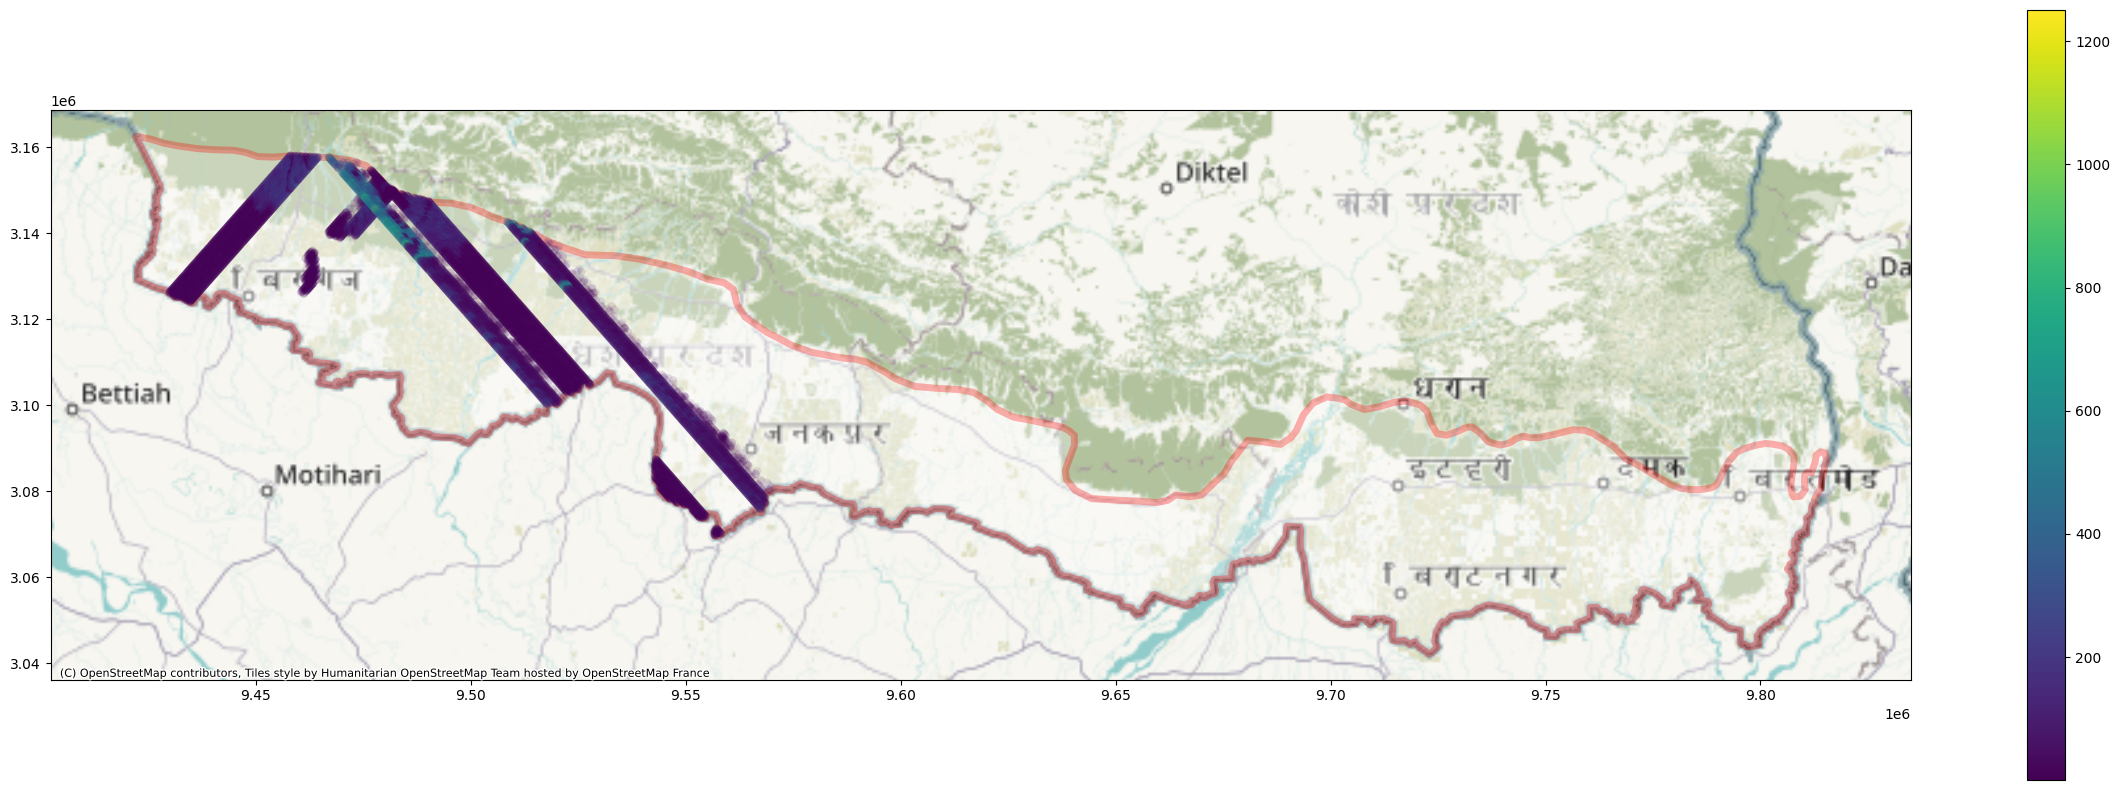

In [107]:
terai_df = pd.DataFrame([[-9999,0,-9999,-9999, Terai_epsg4326.geometry.iloc[0]]], columns=["agbd", "l4_quality_flag","lat_lowestmode", "lon_lowestmode", "geometry"])
gdf = pd.concat([gdf, terai_df])
gdf.crs="EPSG:4326"
gdf_epsg3857 = gdf.to_crs(epsg=3857)
ax4=gdf_epsg3857[-1:].plot(color='white', edgecolor='red', alpha=0.3, linewidth=5, figsize=(30, 10))
gdf_epsg3857[gdf_epsg3857['agbd'] != -9999][:-1].plot(ax=ax4, column='agbd', alpha=0.1, linewidth=0, legend=True)
ctx.add_basemap(ax4)

**4c. Saving the subsets to different formats**

In the step above, we created a HDF5 formatted output, which is the native format of GEDI L4A datasets. The HDF5 files can be output to geojson or csv or ESRI Shapefile using the geopandas.

In [108]:
import h5py
import pandas as pd
import numpy as np
import glob
from os import path

# Directory containing HDF5 subset files
outdir = 'subsets'

# Function to process a single BEAM group
def process_beam_group(beam):
    col_names = []
    col_val = []
    for key, value in beam.items():
        if isinstance(value, h5py.Group):
            # Process subgroup
            for key2, value2 in value.items():
                if key2 != "shot_number":
                    process_key_value(key2, value2, col_names, col_val)
        else:
            # Process dataset in the main group
            process_key_value(key, value, col_names, col_val)

    # Create a DataFrame for this BEAM group
    return pd.DataFrame(map(list, zip(*col_val)), columns=col_names)

# Helper function to process individual keys and values
def process_key_value(key, value, col_names, col_val):
    if key.startswith('xvar'):  # Handle 2D variables
        for r in range(4):
            col_names.append(f"{key}_{r+1}")
            col_val.append(value[:, r].tolist())
    else:  # Handle 1D variables
        col_names.append(key)
        col_val.append(value[:].tolist())

# Main script to process all files and aggregate results
def process_all_h5_files(outdir):
    file_paths = glob.glob(path.join(outdir, 'GEDI04_A*_sub.h5'))
    dfs = []

    for subfile in file_paths:
        with h5py.File(subfile, 'r') as hf_in:
            for v in list(hf_in.keys()):
                if v.startswith('BEAM'):
                    # Process BEAM group and append to list
                    beam_df = process_beam_group(hf_in[v])
                    beam_df.insert(0, 'BEAM', str(v))  # Add BEAM column
                    dfs.append(beam_df)

    # Combine all DataFrames into one
    return pd.concat(dfs, ignore_index=True)

# Execute the script
subset_df = process_all_h5_files(outdir)

# Save the final DataFrame to a CSV file
subset_df.to_csv('subset_data.csv', index=False)

# Print summary
print("Data processing complete.")
print(subset_df.info())


Data processing complete.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38619 entries, 0 to 38618
Columns: 205 entries, BEAM to xvar_4
dtypes: float64(130), int64(73), object(2)
memory usage: 60.4+ MB
None


Now, all the variables are stored in a pandas dataframe subset_df. We can print the dataframe.

In [109]:
# Setting 'shot_number' as dataframe index. shot_number column is unique
subset_df = subset_df.set_index('shot_number')
subset_df.head()

BEAM    agbd  agbd_pi_lower  agbd_pi_upper  agbd_a1  \
shot_number                                                                   
234440000300267137  BEAM0000 -9999.0        -9999.0        -9999.0  -9999.0   
234440000300267138  BEAM0000 -9999.0        -9999.0        -9999.0  -9999.0   
234440000300267139  BEAM0000 -9999.0        -9999.0        -9999.0  -9999.0   
234440000300267140  BEAM0000 -9999.0        -9999.0        -9999.0  -9999.0   
234440000300267141  BEAM0000 -9999.0        -9999.0        -9999.0  -9999.0   

                    agbd_a10  agbd_a2  agbd_a3  agbd_a4  agbd_a5  ...  \
shot_number                                                       ...   
234440000300267137   -9999.0  -9999.0  -9999.0  -9999.0  -9999.0  ...   
234440000300267138   -9999.0  -9999.0  -9999.0  -9999.0  -9999.0  ...   
234440000300267139   -9999.0  -9999.0  -9999.0  -9999.0  -9999.0  ...   
234440000300267140   -9999.0  -9999.0  -9999.0  -9999.0  -9999.0  ...   
234440000300267141   -9999.0  -9999.0  -9999.0  -9999.0  -9999.0  ...   

                    selected_algorithm  selected_mode  selected_mode_flag  \
shot_number                                                                 
234440000300267137                   1              0                   0   
234440000300267138                   1              0                   0   
234440000300267139                   1              0                   0   
234440000300267140                   1              0                   0   
234440000300267141                   1              0                   0   

                    sensitivity  solar_elevation  surface_flag  xvar_1  \
shot_number                                                              
234440000300267137     0.806901       -34.928894             0 -9999.0   
234440000300267138     0.879266       -34.929253             0 -9999.0   
234440000300267139     0.851812       -34.929611             0 -9999.0   
234440000300267140     0.877036       -34.929962             0 -9999.0   
234440000300267141     0.829689       -34.930317             0 -9999.0   

                    xvar_2  xvar_3  xvar_4  
shot_number                                 
234440000300267137 -9999.0 -9999.0 -9999.0  
234440000300267138 -9999.0 -9999.0 -9999.0  
234440000300267139 -9999.0 -9999.0 -9999.0  
234440000300267140 -9999.0 -9999.0 -9999.0  
234440000300267141 -9999.0 -9999.0 -9999.0  

[5 rows x 204 columns]

The dataframe has 204 columns representing GEDI L4A variables. We can export it to a CSV file directly as:

If we want to save the file as one of the geospatial formats (such as GEOJSON, KML, ESRI Shapefile), we need to first convert the dataframe into a geopandas dataframe, and export to various formats.

In [110]:
subset_gdf = gpd.GeoDataFrame(subset_df, geometry=gpd.points_from_xy(subset_df.lon_lowestmode, subset_df.lat_lowestmode))
subset_gdf.crs = "EPSG:4326"

# convert object types columns to strings. object types are not supported
for c in subset_gdf.columns:
    if subset_gdf[c].dtype == 'object':
        subset_gdf[c] = subset_gdf[c].astype(str)

# Export to GeoJSON
#subset_gdf.to_file('subsets/tal_subset.geojson', driver='GeoJSON')
# Export to ESRI Shapefile
subset_gdf.to_file('Terai_subset.shp')

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 152986576.537773252 of field delta_time of feature 36119 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 152986576.546037257 of field delta_time of feature 36120 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 152986576.554301262 of field delta_time of feature 36121 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 152986576.562565237 of field delta_time of feature 36122 not successfully written. Possibly due to too larger number with respect to field width
  